In [1]:

import os
import sys
import sklearn
import pip
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import deeplake
from time import time
from PIL import Image


from pathlib import Path
# set figure size
plt.rcParams['figure.figsize'] = [14, 14]
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Requirements taken from https://www.tensorflow.org/install/pip#linux
python_version = sys.version
pip_version = pip.__version__
nvidia_smi_version = os.popen('nvidia-smi --query-gpu=driver_version --format=csv,noheader').read().strip()
cuda_version = os.popen('nvcc --version').read().split('\n')[3].split(',')[1].strip()
tensorflow_version = tf.__version__
physical_devices = tf.config.list_physical_devices('GPU')
num_gpus = len(physical_devices)
gpu_model = os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read().strip()

req_xray_data = pd.DataFrame({
    'Package': ['Python', 'pip', 'nvidia-smi', 'cuda', 'tensorflow', 'GPUs'],
    'Required': ['3.7', '20.2', '450.51.06', '11.0', '2.3.0', '1'],
    'Installed': [python_version, pip_version, nvidia_smi_version, cuda_version, tensorflow_version, num_gpus]
})
               
print(f'All requiremetns met. Using TF with GPU: {gpu_model} ({num_gpus}x)')

pd.options.plotting.backend = "plotly"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

from keras.models import Model, Sequential
from keras.layers import Lambda, Input, GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, GlobalMaxPooling2D, Add, multiply, Permute, Concatenate
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import keras
from sklearn.metrics import classification_report, accuracy_score
from keras.regularizers import l2
import keras.backend as K

import sys

sys.path.append('/home/kayaba_attribution/Documents/UoL/FINAL_PROJECT/Code/nih-chest')
sys.path.append(os.path.dirname(os.getcwd()))

from dataset import train_ds, val_ds, test_ds, y_test, y_val, ALL_LABELS, IMG_SIZE
from reportUtils import generate_report

MODEL_NAME = 'ResNet18CBAM'

req_xray_data


2024-03-24 23:44:46.149095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 23:44:46.149130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 23:44:46.150844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 23:44:46.157639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 23:44:47.003147: W tensorflow/compiler/tf2

All requiremetns met. Using TF with GPU: NVIDIA GeForce GTX 1660 (1x)
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


2024-03-24 23:44:48.789749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 23:44:49.080918: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 23:44:49.081144: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

,Package,Required,Installed
0,Python,3.7,"3.9.17 (main, Jul 5 2023, 20:41:20) \n[GCC 11..."
1,pip,20.2,23.2.1
2,nvidia-smi,450.51.06,535.54.03
3,cuda,11.0,release 12.2
4,tensorflow,2.3.0,2.15.0
5,GPUs,1,1


In [2]:
def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])


In [3]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """
    2D Convolution-Batch Normalization-Activation stack builder.
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_block(inputs, num_filters, CBAM=False, downsample=False):
    """
    Creates a ResNet block with an optional Convolutional Block Attention Module (CBAM).
    """
    x = inputs
    if downsample:
        inputs = resnet_layer(inputs=inputs, num_filters=num_filters, kernel_size=1, strides=2, activation=None, batch_normalization=True)
    
    x = resnet_layer(inputs=x, num_filters=num_filters, strides=2 if downsample else 1)
    x = resnet_layer(inputs=x, num_filters=num_filters, activation=None)
    
    if CBAM:
        x = cbam_block(x)  # Applies CBAM if flagged
    
    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

def resnet_18(input_shape, num_classes=10, use_cbam=False):
    """
    Builds a ResNet-18 model with an optional CBAM.
    """
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, num_filters=64, kernel_size=7, strides=2, activation='relu', batch_normalization=True)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Defines each stage of ResNet-18
    for stage in [(64, False), (128, True), (256, True), (512, True)]:
        num_filters, downsample = stage
        x = resnet_block(x, num_filters, CBAM=use_cbam, downsample=downsample)
        x = resnet_block(x, num_filters, CBAM=use_cbam)
        
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='sigmoid', kernel_initializer='he_normal')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
model = resnet_18(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=15)

plot_model(model, f"{MODEL_NAME}_model.png", show_shapes=True, show_layer_names=True)
weight_path=f"{MODEL_NAME}_weights.best.hdf5"

# https://keras.io/api/callbacks/model_checkpoint/
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min',
    save_weights_only = True)

# https://keras.io/api/callbacks/early_stopping/
earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-4,
    patience = 5,
    mode = 'min', 
    restore_best_weights = True,
    verbose = 1)

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-6)


callbacks_list = [checkpoint, earlystop, reduceLROnPlat]


import keras.backend as K

weights = {
        0: 1.,
        1: 5.
}

def weighted_cross_entropy_fn(y_true, y_pred):
     tf_y_true = tf.cast(y_true, dtype=y_pred.dtype)
     tf_y_pred = tf.cast(y_pred, dtype=y_pred.dtype)
     weights_v = tf.where(tf.equal(tf_y_true, 1), weights[1], weights[0])
     weights_v = tf.cast(weights_v, dtype=y_pred.dtype)
     ce = K.binary_crossentropy(tf_y_true, tf_y_pred, from_logits=False)
     loss = K.mean(tf.multiply(ce, weights_v))
     return loss
 
def get_weighted_loss():
    def loss(y_true, y_pred):
        return weighted_cross_entropy_fn(y_true, y_pred)
    return loss


model.compile(optimizer='adam', 
              loss=get_weighted_loss(),
                metrics=[
                    keras.metrics.BinaryAccuracy(name='accuracy'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc', multi_label=True)])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [7]:
# Check if weight checkpoint exists
if os.path.exists(weight_path):
    print("Loading weights from:", weight_path)
    model.load_weights(weight_path)
else:
    print("No weights found, starting training from scratch.")

start = time()
history = model.fit(
                    train_ds,
                    epochs=4,
                    validation_data=val_ds,
                    callbacks=callbacks_list
                    )
print('\nTraining took {} sec'.format((time()-start)))
model.save(f"{MODEL_NAME}.keras")


No weights found, starting training from scratch.
Epoch 1/4


2024-03-24 23:47:50.825363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 278/2704 [==>...........................] - ETA: 6:37 - loss: 0.5121 - accuracy: 0.9167 - precision: 0.4761 - recall: 0.6717 - auc: 0.7894

2024-03-24 23:48:36.356761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


2704/2704 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.9012 - precision: 0.4266 - recall: 0.6604 - auc: 0.7514
Epoch 1: val_loss improved from inf to 0.76199, saving model to ResNet18CBAM_weights.best.hdf5
2704/2704 [==============================] - 495s 183ms/step - loss: 0.5504 - accuracy: 0.9012 - precision: 0.4266 - recall: 0.6604 - auc: 0.7514 - val_loss: 0.7620 - val_accuracy: 0.8123 - val_precision: 0.2776 - val_recall: 0.6325 - val_auc: 0.6369 - lr: 0.0010
Epoch 2/4


2024-03-24 23:56:05.389457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 278/2704 [==>...........................] - ETA: 6:32 - loss: 0.5262 - accuracy: 0.9171 - precision: 0.4767 - recall: 0.6352 - auc: 0.7216

2024-03-24 23:56:50.294031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


2704/2704 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.9026 - precision: 0.4313 - recall: 0.6579 - auc: 0.7379
Epoch 2: val_loss improved from 0.76199 to 0.73697, saving model to ResNet18CBAM_weights.best.hdf5
2704/2704 [==============================] - 474s 175ms/step - loss: 0.5290 - accuracy: 0.9026 - precision: 0.4313 - recall: 0.6579 - auc: 0.7379 - val_loss: 0.7370 - val_accuracy: 0.8239 - val_precision: 0.2888 - val_recall: 0.6074 - val_auc: 0.6695 - lr: 0.0010
Epoch 3/4


2024-03-25 00:03:59.207322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 278/2704 [==>...........................] - ETA: 6:35 - loss: 0.5086 - accuracy: 0.9186 - precision: 0.4840 - recall: 0.6392 - auc: 0.7144

2024-03-25 00:04:44.449392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


2704/2704 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.9029 - precision: 0.4327 - recall: 0.6626 - auc: 0.7411
Epoch 3: val_loss improved from 0.73697 to 0.72445, saving model to ResNet18CBAM_weights.best.hdf5
2704/2704 [==============================] - 470s 174ms/step - loss: 0.5127 - accuracy: 0.9029 - precision: 0.4327 - recall: 0.6626 - auc: 0.7411 - val_loss: 0.7244 - val_accuracy: 0.8064 - val_precision: 0.2718 - val_recall: 0.6410 - val_auc: 0.6792 - lr: 0.0010
Epoch 4/4


2024-03-25 00:11:49.189456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 278/2704 [==>...........................] - ETA: 6:38 - loss: 0.4981 - accuracy: 0.9187 - precision: 0.4843 - recall: 0.6439 - auc: 0.7196

2024-03-25 00:12:34.722976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


2704/2704 [==============================] - ETA: 0s - loss: 0.5038 - accuracy: 0.9033 - precision: 0.4346 - recall: 0.6671 - auc: 0.7497
Epoch 4: val_loss improved from 0.72445 to 0.71918, saving model to ResNet18CBAM_weights.best.hdf5
2704/2704 [==============================] - 463s 171ms/step - loss: 0.5038 - accuracy: 0.9033 - precision: 0.4346 - recall: 0.6671 - auc: 0.7497 - val_loss: 0.7192 - val_accuracy: 0.8206 - val_precision: 0.2841 - val_recall: 0.6077 - val_auc: 0.6618 - lr: 0.0010

Training took 1901.079151391983 sec


In [8]:
generate_report(model, val_ds, y_val, MODEL_NAME, ALL_LABELS)

459/459 [==============================] - 28s 61ms/step


/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
No Finding,0.441687,0.997368,0.612241,6459.0
Hernia,0.000000,0.000000,0.000000,20.0
Emphysema,0.000000,0.000000,0.000000,549.0
Nodule,0.156863,0.008649,0.016393,925.0
Pneumonia,0.000000,0.000000,0.000000,261.0
Consolidation,0.176471,0.003311,0.006501,906.0
Cardiomegaly,0.274559,0.208015,0.236699,524.0
Effusion,0.340382,0.521327,0.411856,2532.0
Mass,0.187500,0.003250,0.006390,923.0
Pleural_Thickening,0.000000,0.000000,0.000000,588.0


In [9]:
generate_report(model, test_ds, y_test, MODEL_NAME, ALL_LABELS, "test")

15/15 [==============================] - 3s 177ms/step


/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
No Finding,0.066815,1.000000,0.125261,30.0
Hernia,0.000000,0.000000,0.000000,30.0
Emphysema,0.000000,0.000000,0.000000,46.0
Nodule,0.000000,0.000000,0.000000,57.0
Pneumonia,0.000000,0.000000,0.000000,47.0
Consolidation,0.000000,0.000000,0.000000,65.0
Cardiomegaly,0.461538,0.146341,0.222222,41.0
Effusion,0.468085,0.511628,0.488889,129.0
Mass,1.000000,0.013889,0.027397,72.0
Pleural_Thickening,0.000000,0.000000,0.000000,61.0


In [28]:
MODEL_NAME = "ResNet18CBAMtrue"

model_CBAM = resnet_18(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=15, use_cbam=True)

plot_model(model, f"{MODEL_NAME}_model.png", show_shapes=True, show_layer_names=True)
weight_path=f"{MODEL_NAME}_weights.best.hdf5"

model_CBAM.compile(optimizer='adam', 
              loss=get_weighted_loss(),
                metrics=[
                    keras.metrics.BinaryAccuracy(name='accuracy'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc', multi_label=True)])

model_CBAM.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_104 (Conv2D)         (None, 112, 112, 64)         9472      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_80 (Ba  (None, 112, 112, 64)         256       ['conv2d_104[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_92 (Activation)  (None, 112, 112, 64)         0         ['batch_normalization_80

In [29]:
# Check if weight checkpoint exists
if os.path.exists(weight_path):
    print("Loading weights from:", weight_path)
    model_CBAM.load_weights(weight_path)
else:
    print("No weights found, starting training from scratch.", weight_path)

start = time()
history = model_CBAM.fit(
                    train_ds,
                    epochs=4,
                    validation_data=val_ds,
                    callbacks=callbacks_list
                    )
print('\nTraining took {} sec'.format((time()-start)))
model.save(f"{MODEL_NAME}.keras")


No weights found, starting training from scratch. ResNet18CBAMtrue_weights.best.hdf5
Epoch 1/4


2024-03-25 01:40:27.575319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 277/2704 [==>...........................] - ETA: 8:30 - loss: 0.9887 - accuracy: 0.9168 - precision: 0.4734 - recall: 0.5882 - auc: 0.5654

2024-03-25 01:41:31.860343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


2704/2704 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.9042 - precision: 0.4310 - recall: 0.5930 - auc: 0.6040
Epoch 1: val_loss did not improve from 0.71061
2704/2704 [==============================] - 615s 222ms/step - loss: 0.6247 - accuracy: 0.9042 - precision: 0.4310 - recall: 0.5930 - auc: 0.6040 - val_loss: 0.7345 - val_accuracy: 0.8263 - val_precision: 0.2835 - val_recall: 0.5653 - val_auc: 0.5245 - lr: 0.0010
Epoch 2/4


2024-03-25 01:50:33.221169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 277/2704 [==>...........................] - ETA: 8:27 - loss: 0.5334 - accuracy: 0.9208 - precision: 0.4941 - recall: 0.5936 - auc: 0.5875

2024-03-25 01:51:31.230851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


2704/2704 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.9040 - precision: 0.4311 - recall: 0.6027 - auc: 0.6182
Epoch 2: val_loss did not improve from 0.71061
2704/2704 [==============================] - 598s 221ms/step - loss: 0.5462 - accuracy: 0.9040 - precision: 0.4311 - recall: 0.6027 - auc: 0.6182 - val_loss: 0.7311 - val_accuracy: 0.7899 - val_precision: 0.2545 - val_recall: 0.6500 - val_auc: 0.5733 - lr: 0.0010
Epoch 3/4


2024-03-25 02:00:30.802616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 277/2704 [==>...........................] - ETA: 8:29 - loss: 0.5274 - accuracy: 0.9195 - precision: 0.4876 - recall: 0.6003 - auc: 0.5970

2024-03-25 02:01:29.045242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


2704/2704 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.9032 - precision: 0.4289 - recall: 0.6099 - auc: 0.6275
Epoch 3: val_loss did not improve from 0.71061
2704/2704 [==============================] - 597s 221ms/step - loss: 0.5420 - accuracy: 0.9032 - precision: 0.4289 - recall: 0.6099 - auc: 0.6275 - val_loss: 0.7386 - val_accuracy: 0.8157 - val_precision: 0.2723 - val_recall: 0.5842 - val_auc: 0.5357 - lr: 0.0010
Epoch 4/4


2024-03-25 02:10:27.976632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 277/2704 [==>...........................] - ETA: 8:29 - loss: 0.5246 - accuracy: 0.9207 - precision: 0.4935 - recall: 0.5985 - auc: 0.6012

2024-03-25 02:11:26.244220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


2704/2704 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.9038 - precision: 0.4313 - recall: 0.6137 - auc: 0.6350
Epoch 4: val_loss did not improve from 0.71061
2704/2704 [==============================] - 566s 209ms/step - loss: 0.5384 - accuracy: 0.9038 - precision: 0.4313 - recall: 0.6137 - auc: 0.6350 - val_loss: 0.7298 - val_accuracy: 0.8087 - val_precision: 0.2672 - val_recall: 0.6036 - val_auc: 0.5193 - lr: 0.0010

Training took 2376.1039278507233 sec


In [34]:
print(classification_report(y_test, model_CBAM.predict(test_ds).round(), target_names=ALL_LABELS))

15/15 [==============================] - 1s 64ms/step
                    precision    recall  f1-score   support

        No Finding       0.07      1.00      0.12        30
            Hernia       0.00      0.00      0.00        30
         Emphysema       0.00      0.00      0.00        46
            Nodule       0.00      0.00      0.00        57
         Pneumonia       0.00      0.00      0.00        47
     Consolidation       0.00      0.00      0.00        65
      Cardiomegaly       0.00      0.00      0.00        41
          Effusion       0.29      1.00      0.45       129
              Mass       0.00      0.00      0.00        72
Pleural_Thickening       0.00      0.00      0.00        61
       Atelectasis       0.21      0.18      0.19        89
      Pneumothorax       0.00      0.00      0.00        86
          Fibrosis       0.00      0.00      0.00        38
      Infiltration       0.34      1.00      0.51       154
             Edema       0.00      0.00      

/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 2s 62ms/step


Text(0, 0.5, 'True Positive Rate')

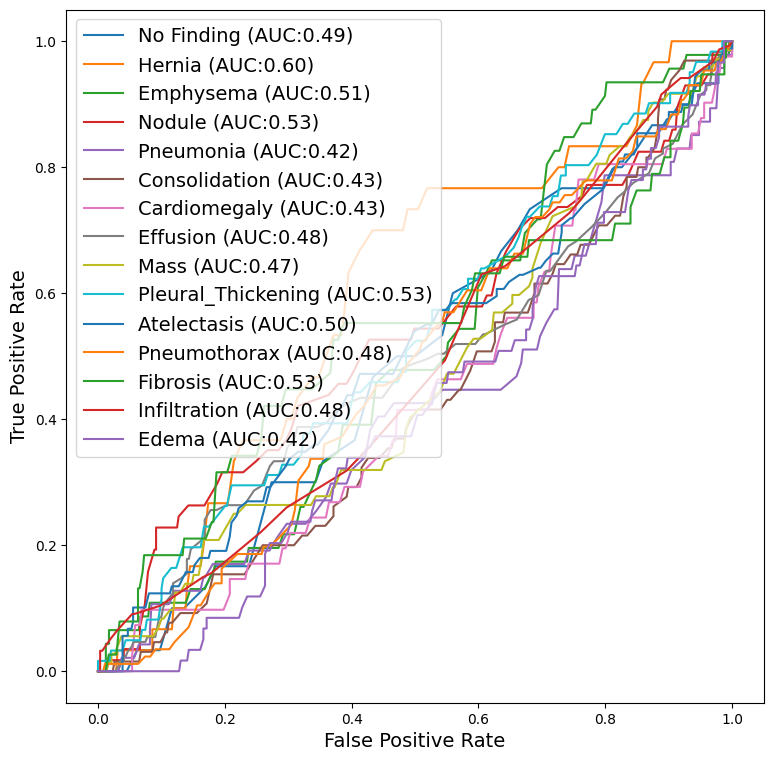

In [30]:
quick_model_predictions = model_CBAM.predict(test_ds, verbose = 1)

# Credit: Helper function for Plotting - Code sourced directly from Kevin Mader - Simple XRay CNN on 12/09/18
# https://www.kaggle.com/kmader/train-simple-xray-cnn

# import libraries
from sklearn.metrics import roc_curve, auc

# create plot
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (i, label) in enumerate(ALL_LABELS):
    fpr, tpr, thresholds = roc_curve(y_test[:,i].astype(int), quick_model_predictions[:,i])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))

# Set labels for plot
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
# fig.savefig('quick_trained_model.png')

In [35]:
if os.path.exists(weight_path):
    print("Loading weights for grad-CAM from:", weight_path)
    model_CBAM.load_weights(weight_path)
else:
    print("No weights found.", weight_path)
    
    
# Layers definitions
from keras import backend as K
for l in range(len(model_CBAM.layers)):
    print(l, model_CBAM.layers[l])


No weights found. ResNet18CBAMtrue_weights.best.hdf5
0 <keras.src.engine.input_layer.InputLayer object at 0x7ff39905d2e0>
1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ff399193340>
2 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff399193f10>
3 <keras.src.layers.core.activation.Activation object at 0x7ff3990b7e80>
4 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff398efbac0>
5 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ff398f037f0>
6 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff398f05730>
7 <keras.src.layers.core.activation.Activation object at 0x7ff398efbeb0>
8 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ff398f0b490>
9 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff398f10b20>
10 <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7ff398f03250>
11 <keras.src.layers.pooling.

In [37]:
# feature extraction layer
getFeature = K.function([model_CBAM.layers[0].input, K.learning_phase()],
                        [model_CBAM.layers[178].output])

# classification layer
getPrediction = K.function([model_CBAM.layers[179].input, K.learning_phase()],
                           [model_CBAM.layers[180].output])

ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: 0

: 

In [ ]:
generate_report(model, val_ds, y_val, MODEL_NAME, ALL_LABELS, "CBAM")

481/481 [==============================] - 31s 64ms/step


/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
No Finding,0.290868,1.000000,0.450655,4475.0
Hernia,0.000000,0.000000,0.000000,4680.0
Emphysema,0.038414,1.000000,0.073986,591.0
Nodule,0.049984,1.000000,0.095209,769.0
Pneumonia,0.075658,1.000000,0.140673,1164.0
Consolidation,0.030614,1.000000,0.059410,471.0
Cardiomegaly,0.000000,0.000000,0.000000,416.0
Effusion,0.000000,0.000000,0.000000,1737.0
Mass,0.000000,0.000000,0.000000,1054.0
Pleural_Thickening,0.032434,1.000000,0.062831,499.0


In [ ]:
generate_report(model, test_ds, y_test, MODEL_NAME, ALL_LABELS, "CBAM_TEST")

1100/1100 [==============================] - 71s 64ms/step


/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
No Finding,0.121324,1.000000,0.216394,4270.0
Hernia,0.000000,0.000000,0.000000,14821.0
Emphysema,0.063020,1.000000,0.118568,2218.0
Nodule,0.057821,1.000000,0.109320,2035.0
Pneumonia,0.128768,1.000000,0.228157,4532.0
Consolidation,0.059099,1.000000,0.111603,2080.0
Cardiomegaly,0.000000,0.000000,0.000000,1257.0
Effusion,0.000000,0.000000,0.000000,4794.0
Mass,0.000000,0.000000,0.000000,2750.0
Pleural_Thickening,0.042193,1.000000,0.080971,1485.0
